# Phenograph clustering

This notebook was retrieved from GitHub as [model201710_model_analyse_single_cells.ipynb](https://github.com/BodenmillerGroup/3D_IMC_publication/blob/main/Python/scripts/single_cell_analysis/model201710_model_analyse_single_cells.ipynb). It was modified to execute phenograph clustering only.

At the end of this document, some phenotypes are recoded based on descriptions in the paper.


In [1]:
## Imports
import scanpy as sc
import numpy as np
import pandas as pd
import phenograph

In [2]:
## File paths
input_base = "../../data/Kuett_2022/MainHer2BreastCancerModel/"
measurements = input_base + 'model201710_mean_intensities.csv'
lable_annotation = input_base + 'model201710_labels_area.csv'

In [3]:
## Load data
adata = sc.read_csv(measurements)
extra_annotation = pd.read_csv(lable_annotation)
adata.obs['cell_labels'] = list(extra_annotation['label'])
adata.obs['cell_labels'] = adata.obs['cell_labels'].astype('category')
adata.obs['cell_volume'] = list(extra_annotation['area'])
adata.obs['cell_volume'] = adata.obs['cell_volume'].astype('int64')

In [9]:
adata ## data structure

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'cell_labels', 'cell_volume'

In [7]:
## Range normalization to the 99th percentile
## across all cells, for each channel separately
max_each_var = np.percentile(adata.X, 99, axis = 0)
min_each_var = np.min(adata.X,0)
range_var = max_each_var - min_each_var
adata.X = adata.X - min_each_var
adata.X = np.divide(adata.X, range_var)
adata.X[adata.X>1] = 1

sc.pp.neighbors(adata, n_neighbors=10,random_state = 111)
sc.tl.umap(adata,random_state = 111)
#adata.write(results_file)

/home/gesa/.py_venv/phenograph/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
adata ## data structure

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'cell_labels', 'cell_volume'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [45]:
## Phenograph clustering
## Since this is replicable (despite seed)
## skip this step and load the results below
communities, graph, Q = phenograph.cluster(adata.X, k=10, primary_metric= 'manhattan', seed = 10)
print(np.unique(communities))

Finding 10 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 49.71676182746887 seconds
Jaccard graph constructed in 3.3068535327911377 seconds
Wrote graph to binary file in 0.3313634395599365 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.867816
After 3 runs, maximum modularity is Q = 0.869564
Louvain completed 23 runs in 28.383280038833618 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 82.40377998352051 seconds
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36]


In [46]:
np.unique(communities) ## cluster labels

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36])

In [47]:
## Recode cluster 0 to a new cluster number
## for visualization?
largest = max(np.unique(communities))+1
communities = [largest if x == 0 else x for x in communities]
adata.obs['phenograph'] = pd.Categorical(communities)

In [48]:
np.unique(communities) ## cluster labels

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [51]:
adata ## data structure

AnnData object with n_obs × n_vars = 108486 × 25
    obs: 'cell_labels', 'cell_volume', 'phenograph'
    uns: 'neighbors', 'umap', 'dendrogram_phenograph'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

In [52]:
## Save cluster labels to file
outfile = input_base + 'model201710_cluster_labels_phenograph.csv'
adata.obs[['cell_labels', 'phenograph']].to_csv(outfile, index=False)

In [8]:
## Load data from file if previously saved
## to conserve cluster labels
outfile = input_base + 'model201710_cluster_labels_phenograph.csv'
adata.obs['phenograph'] = pd.read_csv(outfile)['phenograph'].values # TODO - merge instead

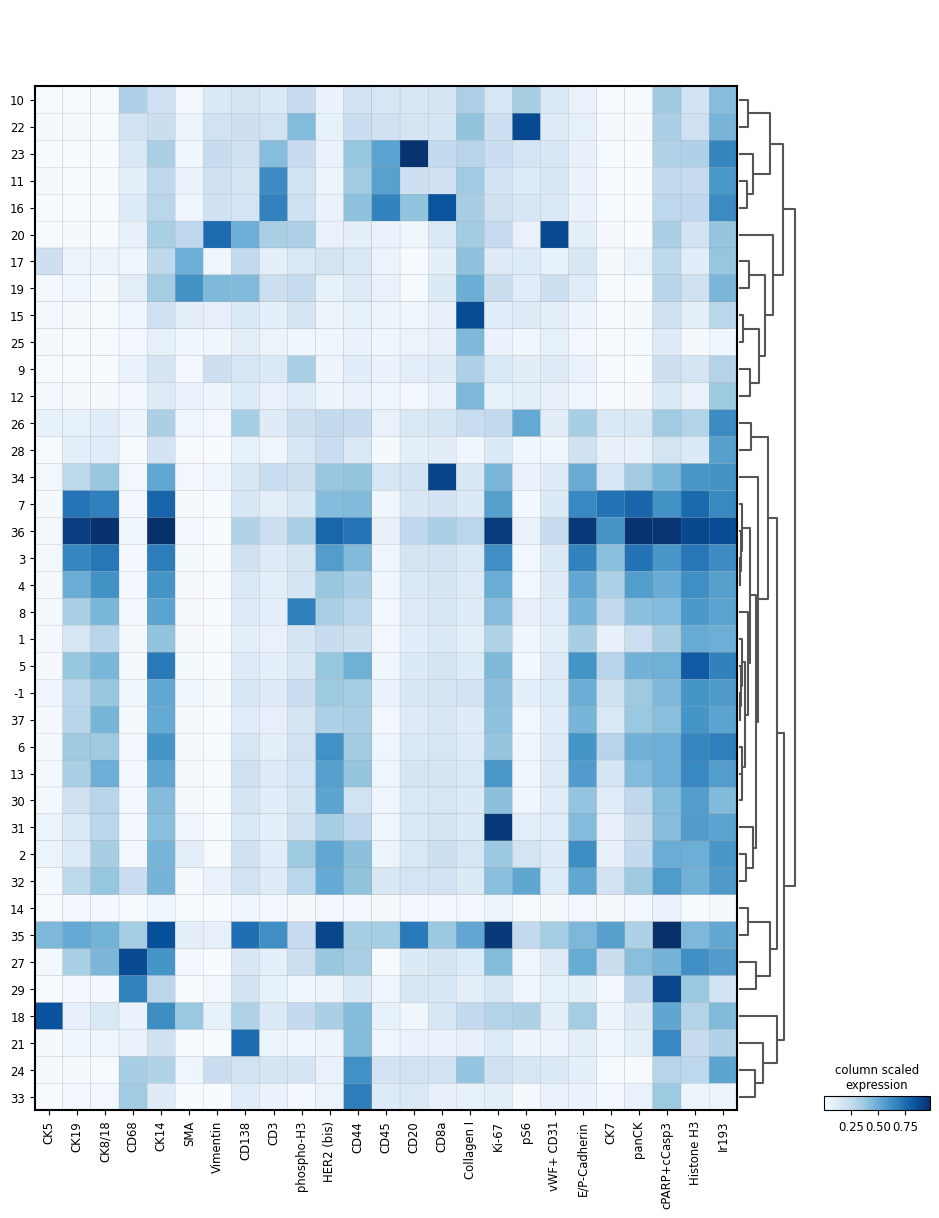

In [68]:
## Plot (as in Fig. 3a)
sc.tl.dendrogram(adata, groupby='phenograph') ## prerequisite for plotting
sc.pl.matrixplot(adata,adata.var_names, 'phenograph', dendrogram=True, cmap='Blues', 
                 colorbar_title='column scaled\nexpression') #, save = '_model201710_median_expression_phenograph.pdf' ) #standard_scale='var', 

In [79]:
## Get number of cells per cluster (as in Fig. 3a)
counts = adata.obs['phenograph'].groupby(adata.obs['phenograph']).count()
counts

/tmp/ipykernel_129424/3671556161.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = adata.obs['phenograph'].groupby(adata.obs['phenograph']).count()


phenograph
-1       129
 1     10055
 2      8992
 3      7392
 4      7278
 5      6664
 6      5479
 7      5319
 8      4025
 9      3935
 10     3810
 11     3202
 12     3042
 13     2462
 14     2151
 15     2035
 16     2014
 17     1992
 18     1859
 19     1721
 20     1663
 21     1232
 22     1109
 23     1012
 24      941
 25      904
 26      841
 27      837
 28      687
 29      574
 30      537
 31      389
 32      353
 33      233
 34      109
 35       69
 36       61
 37    13379
Name: phenograph, dtype: int64

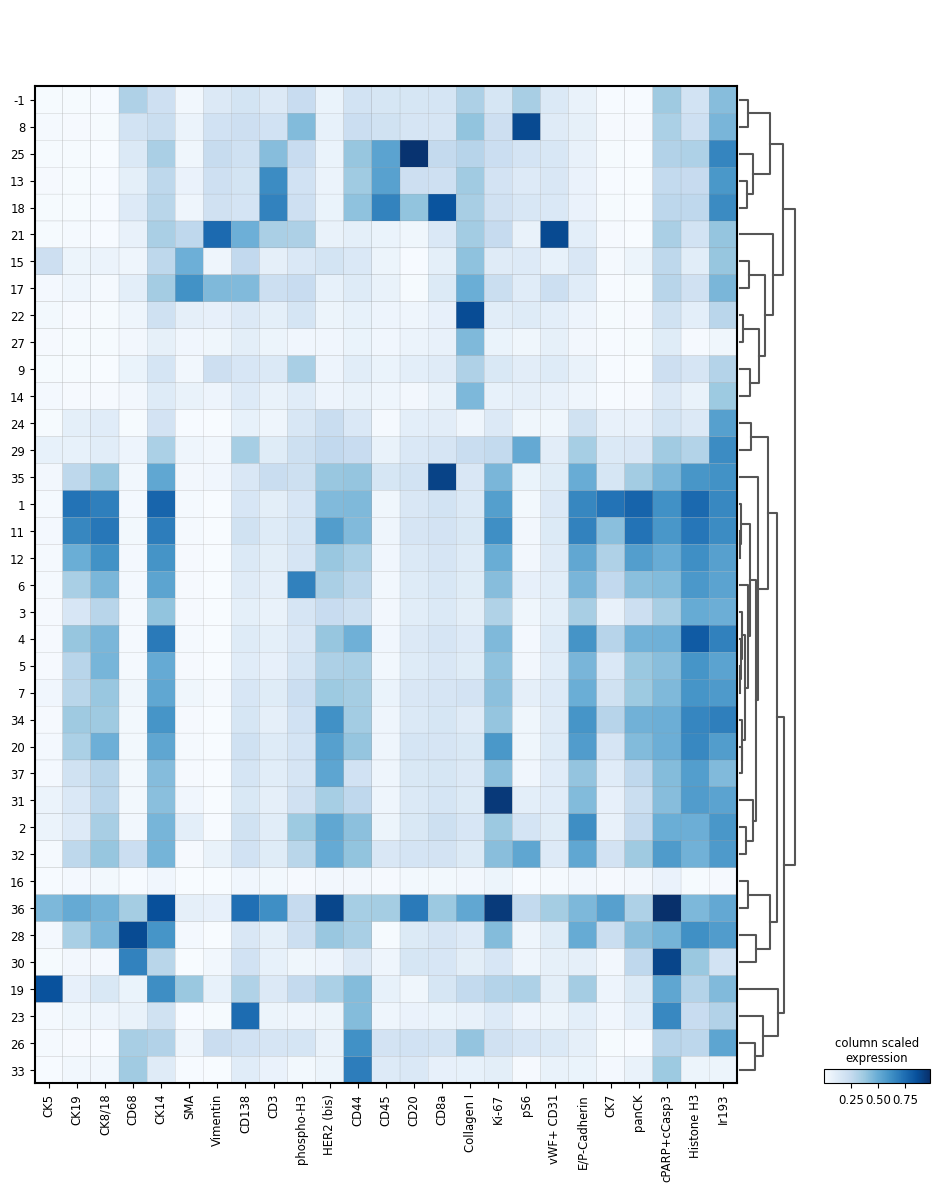

In [24]:
## Re-code labels from here to match the original labels
label_recode = {
    -1:7, 1:3, 2:2, 3:11, 4:12, 5:4, 6:34, 7:1, 8:6, 9:9,
    10:-1, 11:13, 12:14, 13:20, 14:16, 15:22, 16:18, 17:15, 18:19, 19:17,
    20:21, 21:23, 22:8, 23:25, 24:26, 25:27, 26:29, 27:28, 28:24, 29:30,
    30:37, 31:31, 32:32, 33:33, 34:35, 35:36, 36:1, 37:5 }

adata_recoded = adata.copy()
adata_recoded.obs['phenograph'] = adata_recoded.obs['phenograph'].map(label_recode)
adata_recoded.obs['phenograph'] = pd.Categorical(adata_recoded.obs['phenograph'])
## Plot
sc.tl.dendrogram(adata_recoded, groupby='phenograph')
sc.pl.matrixplot(adata_recoded, adata_recoded.var_names, 'phenograph', dendrogram=True, cmap='Blues', 
                 colorbar_title='column scaled\nexpression')

Some clusters are mentioned in the paper and given a more intuitive description. We will recode them here. Cell types that were not described will not be recoded, resulting in a NaN value.

Some ambiguities needed to be resolved:
- Cluster 13 has been described as an epithelial cell as well as a T cell. Since the expression profile is much more similar to cluster 18 (T) than the other epithelial cells, it is recoded as a T cell here. To enable a distinction between the two clusters, cluster 18 is encoded as 'T' and 13 as 'T_CD8a-'. In downstream analyses, the clusters can be recoded to merge 
- Cluster 30 is described as 'macrophage', but also as one of two subtypes of CD86+ cells. It is named here as 'macrophage'.

In [27]:
## Add broad cell type labels
label2description = {1:'epithelial',
                    2:'epithelial',
                    3:'epithelial',
                    4:'epithelial',
                    5:'epithelial',
                    6:'epithelial',
                    7:'epithelial',
                    10:'epithelial',
                    11:'epithelial',
                    12:'epithelial',
                    17:'stromal',
                    22:'stromal',
                    25:'B',
                    18:'T_CD8a-',
                    13:'T',
                    30:'macrophage',
                    28: 'CD86+',
                    21:'endothelial'}
adata_recoded.obs['ct_broad'] = adata_recoded.obs['phenograph'].map(label2description)
adata_recoded.obs['ct_broad'].value_counts()

ct_broad
epithelial     63294
stromal         3756
T               3202
T_CD8a-         2014
endothelial     1663
B               1012
CD86+            837
macrophage       574
Name: count, dtype: int64

In [30]:
## Save to file
outfile = input_base + 'model201710_cluster_labels_phenograph_recoded.csv'

adata_recoded.obs.rename({'cell_labels':'id'}, axis='columns', inplace=True)
adata_recoded.obs[['id', 'phenograph', 'ct_broad']].to_csv(outfile, index=False)

In [1]:
## Save environment/requirements file
import os

os.system("""
    pip freeze > ../../requirements/phenotyping.txt
""")

0